In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

## Data

In [2]:
data_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')
data = data_train.append(X_test, ignore_index=True, sort=False)
data = pd.get_dummies(data, dummy_na=True, drop_first=True)
data.drop('Id', axis=1, inplace=True)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,1,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,1,0,0


In [3]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['SalePrice']
data.isnull().values.any()

False

In [4]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['SalePrice'] = sale_price
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
data.shape

(2919, 289)

In [6]:
train = data.iloc[:1460];
test = data.iloc[1460:];
test.drop('SalePrice', axis=1, inplace=True)

## Splitting and transforming data

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.25, random_state=42)

In [8]:
train_batch = np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [9]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

X_val = torch.from_numpy(X_val.values).float()
y_val = torch.from_numpy(y_val.values).float().view(-1, 1)

In [10]:
X_train.shape

(1095, 288)

In [11]:
model = nn.Sequential(nn.Linear(288,102),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(102,50),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(50,1),
                      nn.ReLU()
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
model

Sequential(
  (0): Linear(in_features=288, out_features=102, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=102, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=50, out_features=1, bias=True)
  (7): ReLU()
)

In [13]:
ps = model(train_batch[0])
ps.shape

torch.Size([22, 1])

In [14]:
epochs = 300

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))

Epoch: 1/300..  Training Loss: inf..  Test Loss: 15.454.. 
Epoch: 2/300..  Training Loss: inf..  Test Loss: 15.454.. 
Epoch: 3/300..  Training Loss: inf..  Test Loss: 15.454.. 
Epoch: 4/300..  Training Loss: inf..  Test Loss: 11.952.. 
Epoch: 5/300..  Training Loss: 4.572..  Test Loss: 2.326.. 
Epoch: 6/300..  Training Loss: 1.804..  Test Loss: 1.205.. 
Epoch: 7/300..  Training Loss: 1.040..  Test Loss: 0.657.. 
Epoch: 8/300..  Training Loss: 0.660..  Test Loss: 0.416.. 
Epoch: 9/300..  Training Loss: 0.541..  Test Loss: 0.369.. 
Epoch: 10/300..  Training Loss: 0.506..  Test Loss: 0.363.. 
Epoch: 11/300..  Training Loss: 0.502..  Test Loss: 0.359.. 
Epoch: 12/300..  Training Loss: 0.474..  Test Loss: 0.351.. 
Epoch: 13/300..  Training Loss: 0.475..  Test Loss: 0.339.. 
Epoch: 14/300..  Training Loss: 0.469..  Test Loss: 0.333.. 
Epoch: 15/300..  Training Loss: 0.454..  Test Loss: 0.327.. 
Epoch: 16/300..  Training Loss: 0.435..  Test Loss: 0.316.. 
Epoch: 17/300..  Training Loss: 0.426

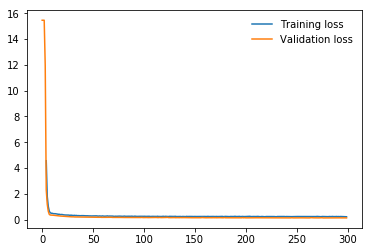

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [16]:
test = torch.from_numpy(test.values).float()
model.eval()
output = model.forward(test)
output.shape

torch.Size([1459, 1])

In [17]:
submission = pd.read_csv('data/sample_submission.csv')
submission['SalePrice'] = output.detach().numpy()
submission.to_csv('submission.csv', index=False)

In [18]:
submission.head()

,Id,SalePrice
0,1461,114515.843750
1,1462,153945.265625
2,1463,176706.671875
3,1464,190572.484375
4,1465,202145.171875
